In [10]:
!pip install -U -q pandas numpy matplotlib seaborn scipy scikit-learn 

In [11]:
from IPython.display import HTML
from IPython.display import YouTubeVideo
styles = open("./custom.css", "r").read()
HTML(styles)

### Poisson Regression Approach

In Part 1, I demonstrated how we can use linear regression to model a relationship between liver function tests and alcohol consumption under an assumption that our target variable is continuous. 

In this tutorial, I will update this assumption. The study participant reported alcohol consumption actully follows a Poisson distribution since the target variable is number of half-pint drinks consumed per day. This value is discrete and non-negative. Therefore, we can use Poissson Regression to model the outcome. We must assume that mean and variance are the same and equal Poisson distribution parameter $\lambda$.

Poisson distribution probability mass function is defined as $\text{Pr}(Y=k) = \Large \frac{e^{-k}\lambda^k}{k!}$. Then, given a generalized regression model for $p$ parameters
$$
\eta (\text{E}(Y|X_1, ..., X_p)) = \beta_0 + \beta_1 x_1 + ... + \beta_p x_p
$$
Setting $\eta(\mu) = \log(\mu)$ can help us model the outcome as Poisson R.V. 

Modeling the outcome with the help of Poisson regression is better than modeling the logarithm of the outcome because it will help with the interpretation of the coefficients.

In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import rc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats import descriptivestats as ds
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import normalize

In [2]:
# define matplotlib styles

sns.set_style('ticks')
sns.set_palette('colorblind')

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':8})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})

rc('axes', **{'labelsize':9, 'titlesize':9, 'linewidth':1})
rc('xtick', **{'labelsize':8})
rc('ytick', **{'labelsize':8})

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['figure.figsize'] = 4, 4

%config InlineBackend.figure_format = 'retina'

In [3]:
# import the dataset

liver_disorders = pd.read_csv('bupa.data', header=None)
liver_disorders.columns = ['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks', 'selector']

# define target variable and features

target = liver_disorders['drinks']

features = ['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt']
X = liver_disorders[features]

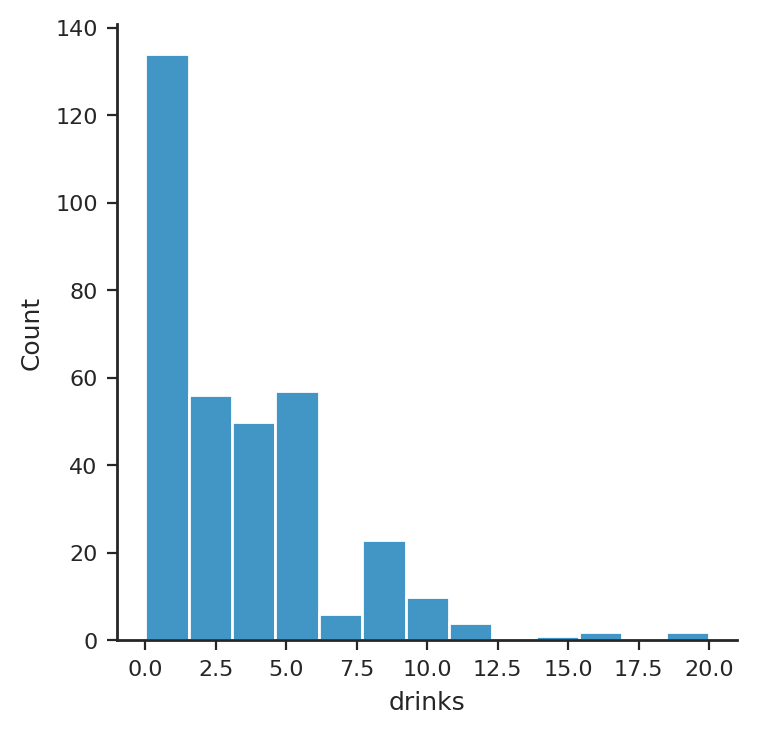

In [4]:
sns.histplot(target)
plt.show()

In [53]:
X = add_constant(X)

In [144]:
# create a baseline model
model = sm.GLM(target, X, family=sm.families.Poisson())
results = model.fit()
predictions = results.predict(X)
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 drinks   No. Observations:                  345
Model:                            GLM   Df Residuals:                      339
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -881.40
Date:                Fri, 07 Feb 2025   Deviance:                       852.92
Time:                        11:46:08   Pearson chi2:                     861.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4043
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.1411      0.633     -6.539      0.0

Poisson regression does evaluation is not based on $R^2$ because $R^2$ calculation utilizes the assumption of normal distribution in order to calculate 95% confidence interval and its standard error SE. 

Instead, other metrics like $\chi^2$ goodness of fit test can be used. It looks like `statsmodels` only provides Pearson Chi2 without the p-value but we can already tell that the $\chi^2$ is huge.

Changes in the deviance can be used to test the null hypothesis that any subset of coefficients is equal to 0

In [145]:
print(f'chi2 p-value: {1 - stats.chi2.cdf(861., 1):.5f}')

chi2 p-value: 0.00000


In [146]:
print(f"""
Prediction mean: {np.mean(predictions):.5f}
Prediction variance: {np.var(predictions):.5f}
""")


Prediction mean: 3.45507
Prediction variance: 2.29038



<div class="summary">

Based on goodness of fit test, the Poisson regression model fits the data pretty well. Since prediction value variance is lower than its mean, the model is underdispersed. This may be due to model predicting to extreme values due to points of high leverage. 

Statsmodels also provides psudo-$R^2$ by Cox and Snell which, in essence, compares the outcome of the model with that which would be produced by a null model. 

alkphos and sgpt appear to have high p-values, which we also saw in the linear regression analysis. 
    
</div>

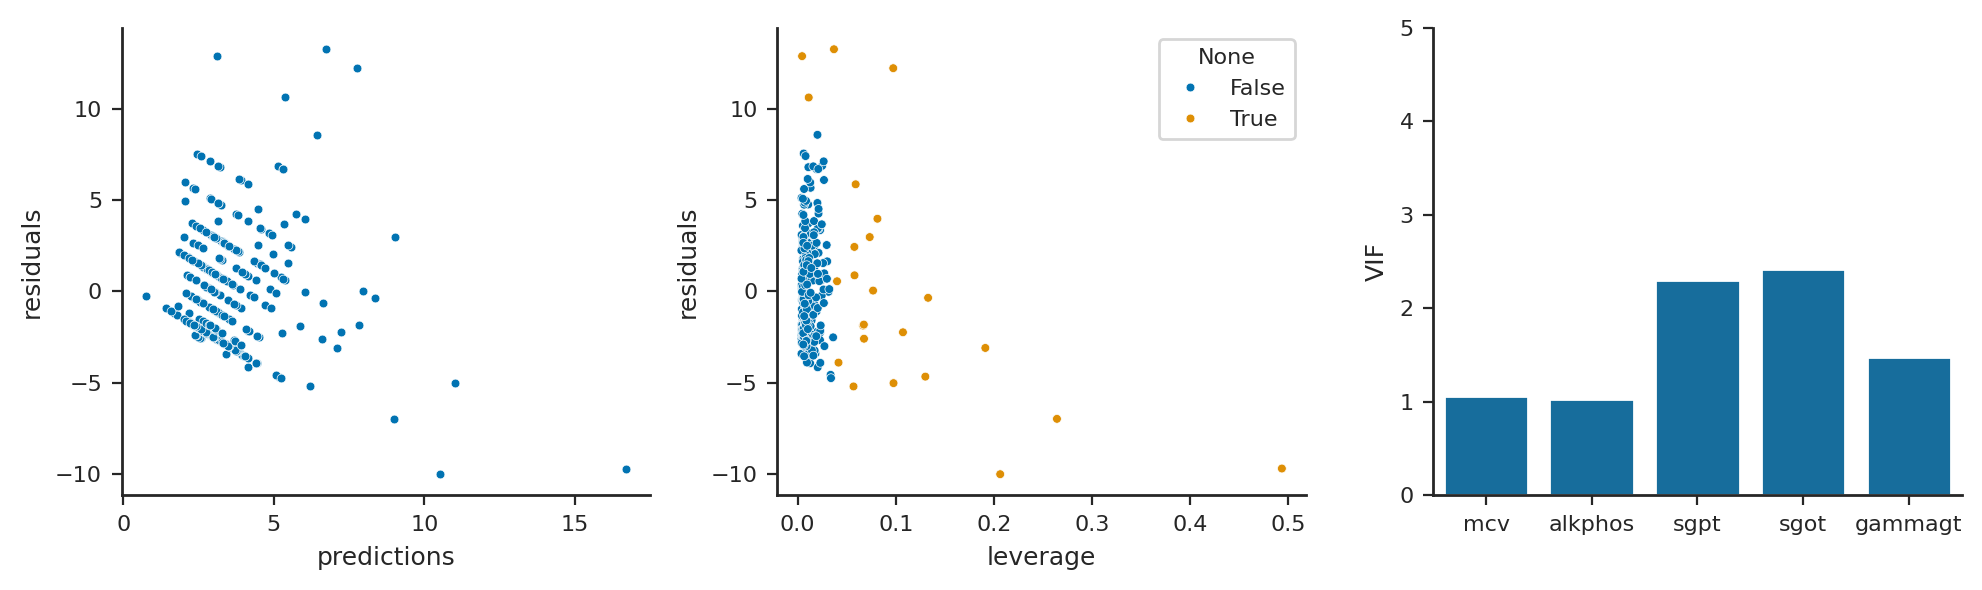

In [147]:
# get additional metrics to evaluate the model and make adjustments

influence = results.get_influence()
leverage = influence.hat_matrix_diag  # leverage detect extereme x values

variables = results.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])][1:]

residuals = target - predictions

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

sns.scatterplot(x=predictions, y=residuals, ax=axes[0], s=10)
axes[0].set_xlabel('predictions')
axes[0].set_ylabel('residuals')

extreme_values_indexes = (leverage>0.04) | (np.abs(residuals)>10)
sns.scatterplot(x=leverage, y=residuals, hue=extreme_values_indexes, ax=axes[1], s=10)
axes[1].set_xlabel('leverage')
axes[1].set_ylabel('residuals')

sns.barplot(x=features, y=vif, ax=axes[2])
axes[2].set_ylim(0, 5)
axes[2].set_ylabel('VIF')

plt.tight_layout()

plt.show()

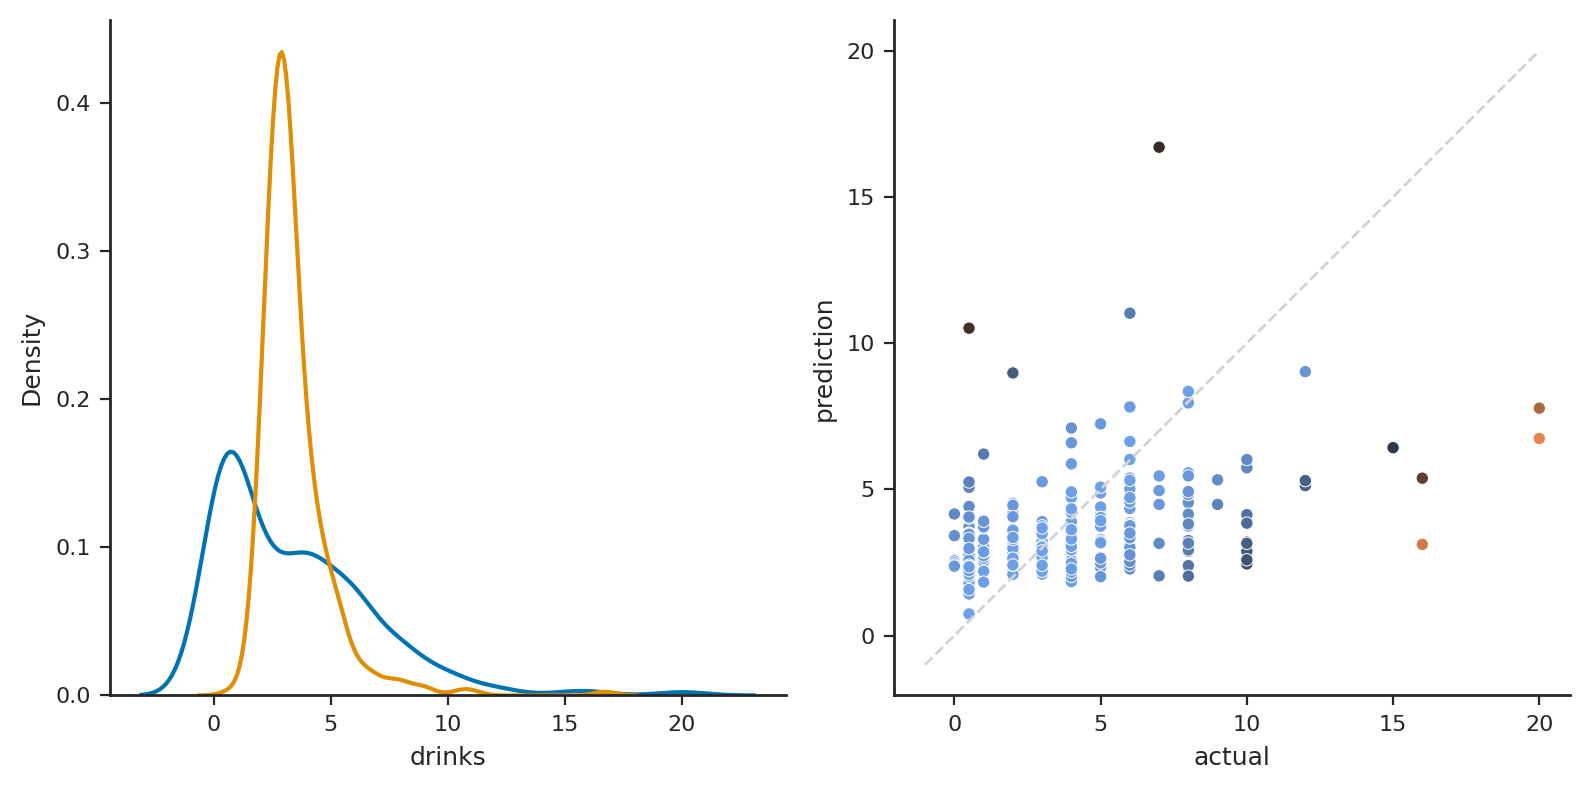

In [153]:
# get additional metrics to evaluate the model and make adjustments

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.kdeplot(target, ax=axes[0])
sns.kdeplot(predictions, ax=axes[0])

sns.scatterplot(x=target, y=predictions, hue=np.square(target - predictions), 
                palette=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True),
                s=20)
sns.lineplot(x=np.linspace(-1, 20, 10), y=np.linspace(-1, 20, 10), lw=1, linestyle='--', color='lightgray', ax=axes[1])
axes[1].set_ylabel('prediction')
axes[1].set_xlabel('actual')

plt.legend().set_visible(False)
plt.tight_layout()

plt.show()

In [150]:
print(f"MSE: {np.mean(np.square(target-predictions)):.5f}")

MSE: 9.38099


In [120]:
print(f"Removing {np.sum(extreme_values_indexes)} extreme values")

Removing 24 extreme values


In [143]:
# remove extreme values we found
X_new = X[~extreme_values_indexes]
target_new = target[~extreme_values_indexes]

model = sm.GLM(target_new, X_new, family=sm.families.Poisson())
results = model.fit()

print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 drinks   No. Observations:                  321
Model:                            GLM   Df Residuals:                      315
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -755.92
Date:                Fri, 07 Feb 2025   Deviance:                       685.25
Time:                        11:46:02   Pearson chi2:                     697.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3771
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7552      0.702     -6.778      0.0

In [122]:
print(f"""
Prediction mean: {np.mean(results.predict(X_new)):.5f}
Prediction variance: {np.var(results.predict(X_new)):.5f}
""")


Prediction mean: 3.16355
Prediction variance: 1.68661



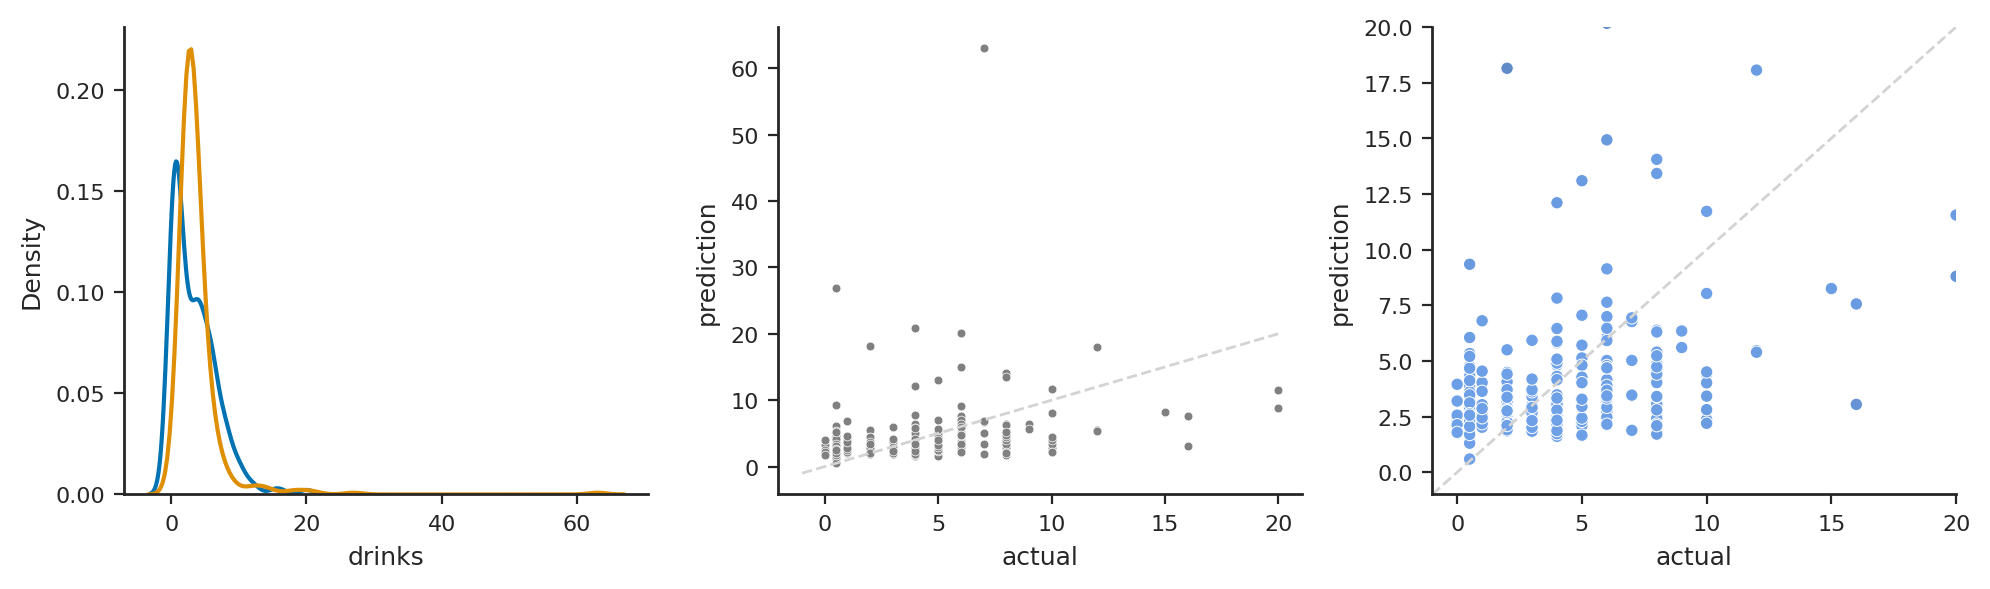

In [133]:
# get additional metrics to evaluate the model and make adjustments

predictions = results.predict(X)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

sns.kdeplot(target, ax=axes[0])
sns.kdeplot(predictions, ax=axes[0])

sns.scatterplot(x=target, y=predictions, ax=axes[1], s=10, color='gray')
sns.lineplot(x=np.linspace(-1, 20, 10), y=np.linspace(-1, 20, 10), lw=1, linestyle='--', color='lightgray', ax=axes[1])
axes[1].set_ylabel('prediction')
axes[1].set_xlabel('actual')

sns.scatterplot(x=target, y=predictions, hue=np.square(target - predictions), 
                palette=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True),
                s=20)
sns.lineplot(x=np.linspace(-1, 20, 10), y=np.linspace(-1, 20, 10), lw=1, linestyle='--', color='lightgray', ax=axes[2])
axes[2].set_ylabel('prediction')
axes[2].set_xlabel('actual')
axes[2].set_ylim(-1, 20)
axes[2].set_xlim(-1, 20)


plt.legend().set_visible(False)
plt.tight_layout()

plt.show()

In [134]:
print(f"MSE: {np.mean(np.square(target-predictions)):.5f}")

MSE: 22.13364


In [142]:
print(f"MSE, after removing the big outlier: {np.mean(np.square(target[~(predictions>30)]-predictions[~(predictions>30)])):.5f}")

MSE, after removing the big outlier: 13.08037


<div class="summary">

After removing extreme values and re-modeling our dataset, the variance of predictions actually decreased but it appears that when predicting the original dataset, the new model has yielded a few extreme predictions on its own. At the same time, the density functions of the target feature appear much closer together. 

MSE has increased drastically, however. Perhaps, the Poisson model is pretty robust to outliers and removing them is causing the model to have worse performance. This is likely because the $\lambda$ of target variable Poisson distribution is quite low and that is causing a long tail on the right hand side. 

Therefore, in this case, it may be better to make inference from the original model. 
    
</div>

In [154]:
# create a baseline model
model = sm.GLM(target, X, family=sm.families.Poisson())
results = model.fit()
predictions = results.predict(X)
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 drinks   No. Observations:                  345
Model:                            GLM   Df Residuals:                      339
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -881.40
Date:                Fri, 07 Feb 2025   Deviance:                       852.92
Time:                        11:50:34   Pearson chi2:                     861.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4043
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.1411      0.633     -6.539      0.0

In [155]:
print(f"MSE: {np.mean(np.square(target-predictions)):.5f}")

MSE: 9.38099


## Results of Poisson Regression

**Does Poisson model perform better than the linear model?**

Since linear and Poisson regression models are based on different assumptions, we don't have as many options in comparing the results. One way we can check if the new model performs better than the linear model is to compare MSEs of targets and predictions across the two models. In linear regression, MSE is 9.31 while MSE in the new model is 9.38. Hence, the two model perform fairly similarly, except that Poisson regression MSE is based on the baseline model which did not remove outliers or points of high leverage while linear regeression MSE is taked after changes to the original data. 

Nonetheless, due to the nature of the outcome variable, the Poisson distribution models the outcome more accurately than the linear regression is Poisson regression is an optimal choice since it aims to predict discrete non-negative values. In Part 1, the linear model actually predicted negative alcohol consumption which is not possible. 

**How do model features relate to the outcome?**

The p-value of ALT (`sgpt`) is too very high so should cannot be used to infer alcohol consumption. As described in Part 1, this is likely due to a parabolic relationship between ALT and alcohol consumption. If our significance threshold is 5%, then AST (`sgot`) could be a predictor. What about APT (`alkphos`)? The p-value is just above out threshold so it could be reasonable to include it in our inference with a caveat that it is possible that APT is a predictor of alcohol consumption but we cannot say for certain. 

Interpretation of Poisson regression coefficients requires us to first take the exponent of them. Then, it can be stated that a change in $x_j$ is associated with a change in $e^{\beta_j}$ change in $y$.


In [161]:
results.params.map(np.exp)-1

const     -0.984095
mcv        0.054804
alkphos    0.002900
sgpt      -0.000404
sgot       0.007170
gammagt    0.003619
dtype: float64

After the transformation, we can see that an increase in a unit of MCV in associated with 5% increase in daily alcohol consumption. The remaining values probably account for less than 1% increase. These values appear to be much lower than the values in our linear regression model but the outcome is more likely to be a representation of what is actually going on and the influence of confounding variables may be significant in inferring alcohol consumption.

